# Analytics - reference-only analysis

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import scvi
from scvi.criticism import PosteriorPredictiveCheck as PPC
from ppc_plot_utils import PPCPlot
import anndata
import pandas as pd
import scanpy as sc
import gc
import matplotlib.pyplot as plt
import mplscience
from pathlib import Path
from scvi.data._download import _download
from scvi.data import cellxgene
import os
from scvi.model.base import ArchesMixin
import warnings
from sparse import SparseArray
from typing import Optional
from scipy.sparse import csr_matrix
import numpy as np

scvi.settings.seed = 0

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/cupy/_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed 

## 1️⃣ Load the model and raw data

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [5]:
local_dir = "/home/cane/Documents/yoseflab/can/scvi-hub"

In [6]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
_download(model_url, local_dir, "model.pt")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


Download the raw counts:

In [7]:
adata_url = "https://cellxgene.cziscience.com/e/066943a2-fdac-4b29-b348-40cede398e4e.cxg/"
b = scvi.data.cellxgene(adata_url, filename="hlca_core.h5ad", save_path=local_dir, census_version="2023-12-15")

In [112]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)

In [114]:
adata = cellxgene(adata_url, filename="hlca_core.h5ad", save_path=local_dir)

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


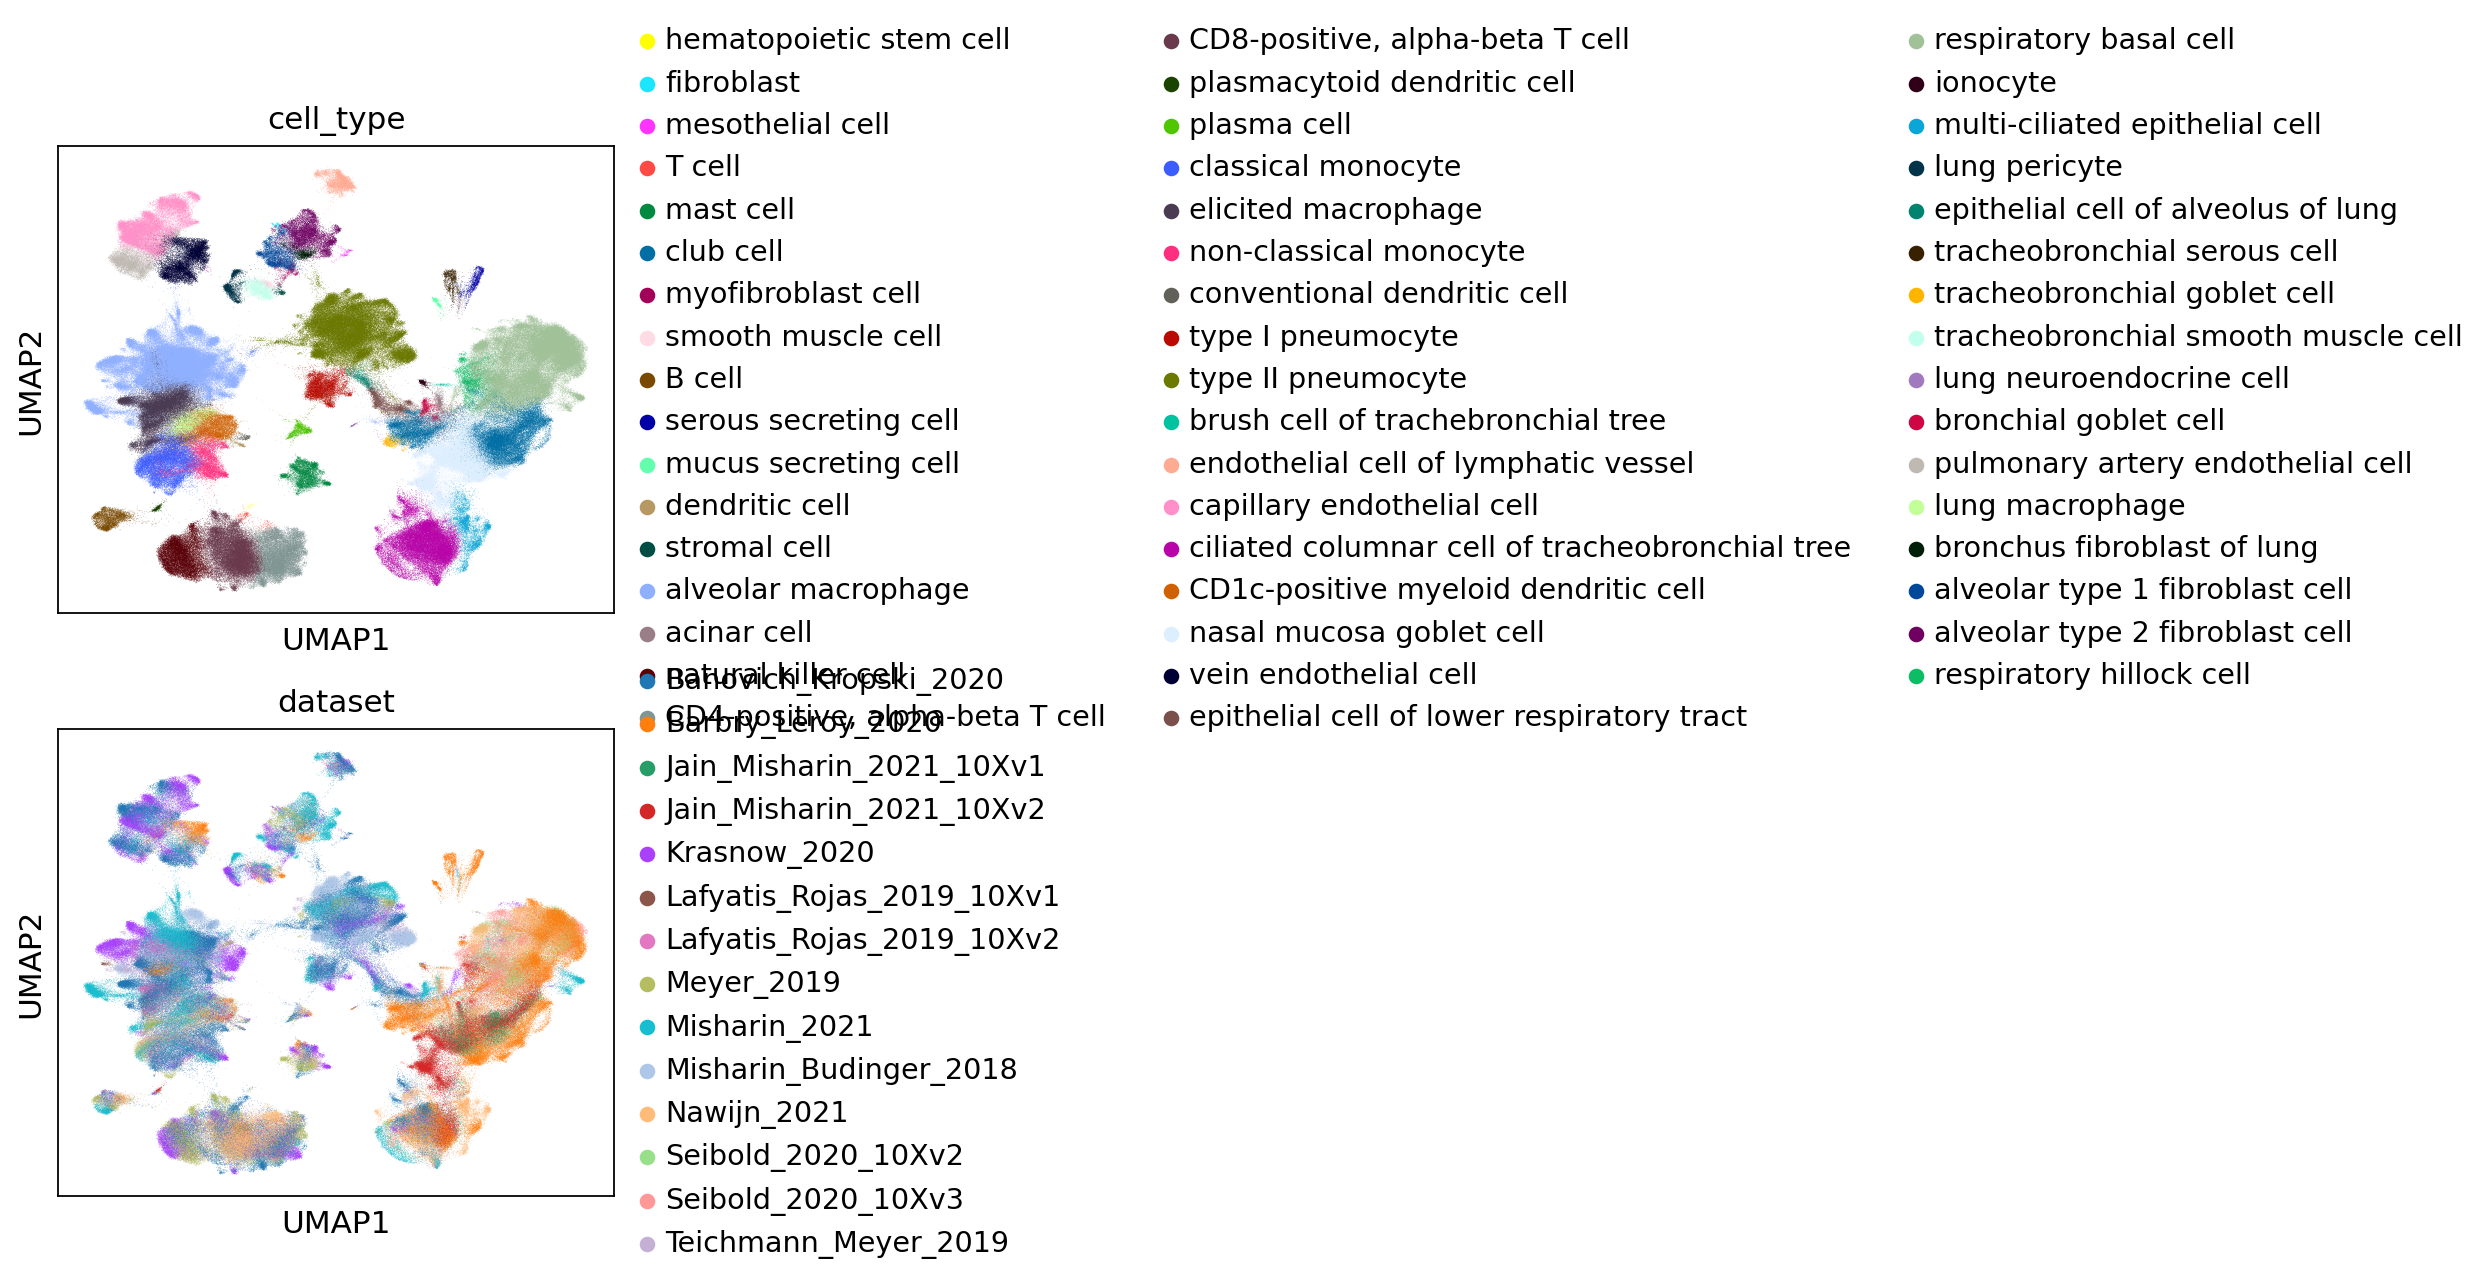

In [115]:
sc.pl.umap(adata, color=["cell_type", "dataset"], save="_cell_type.svg", ncols=1) 

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


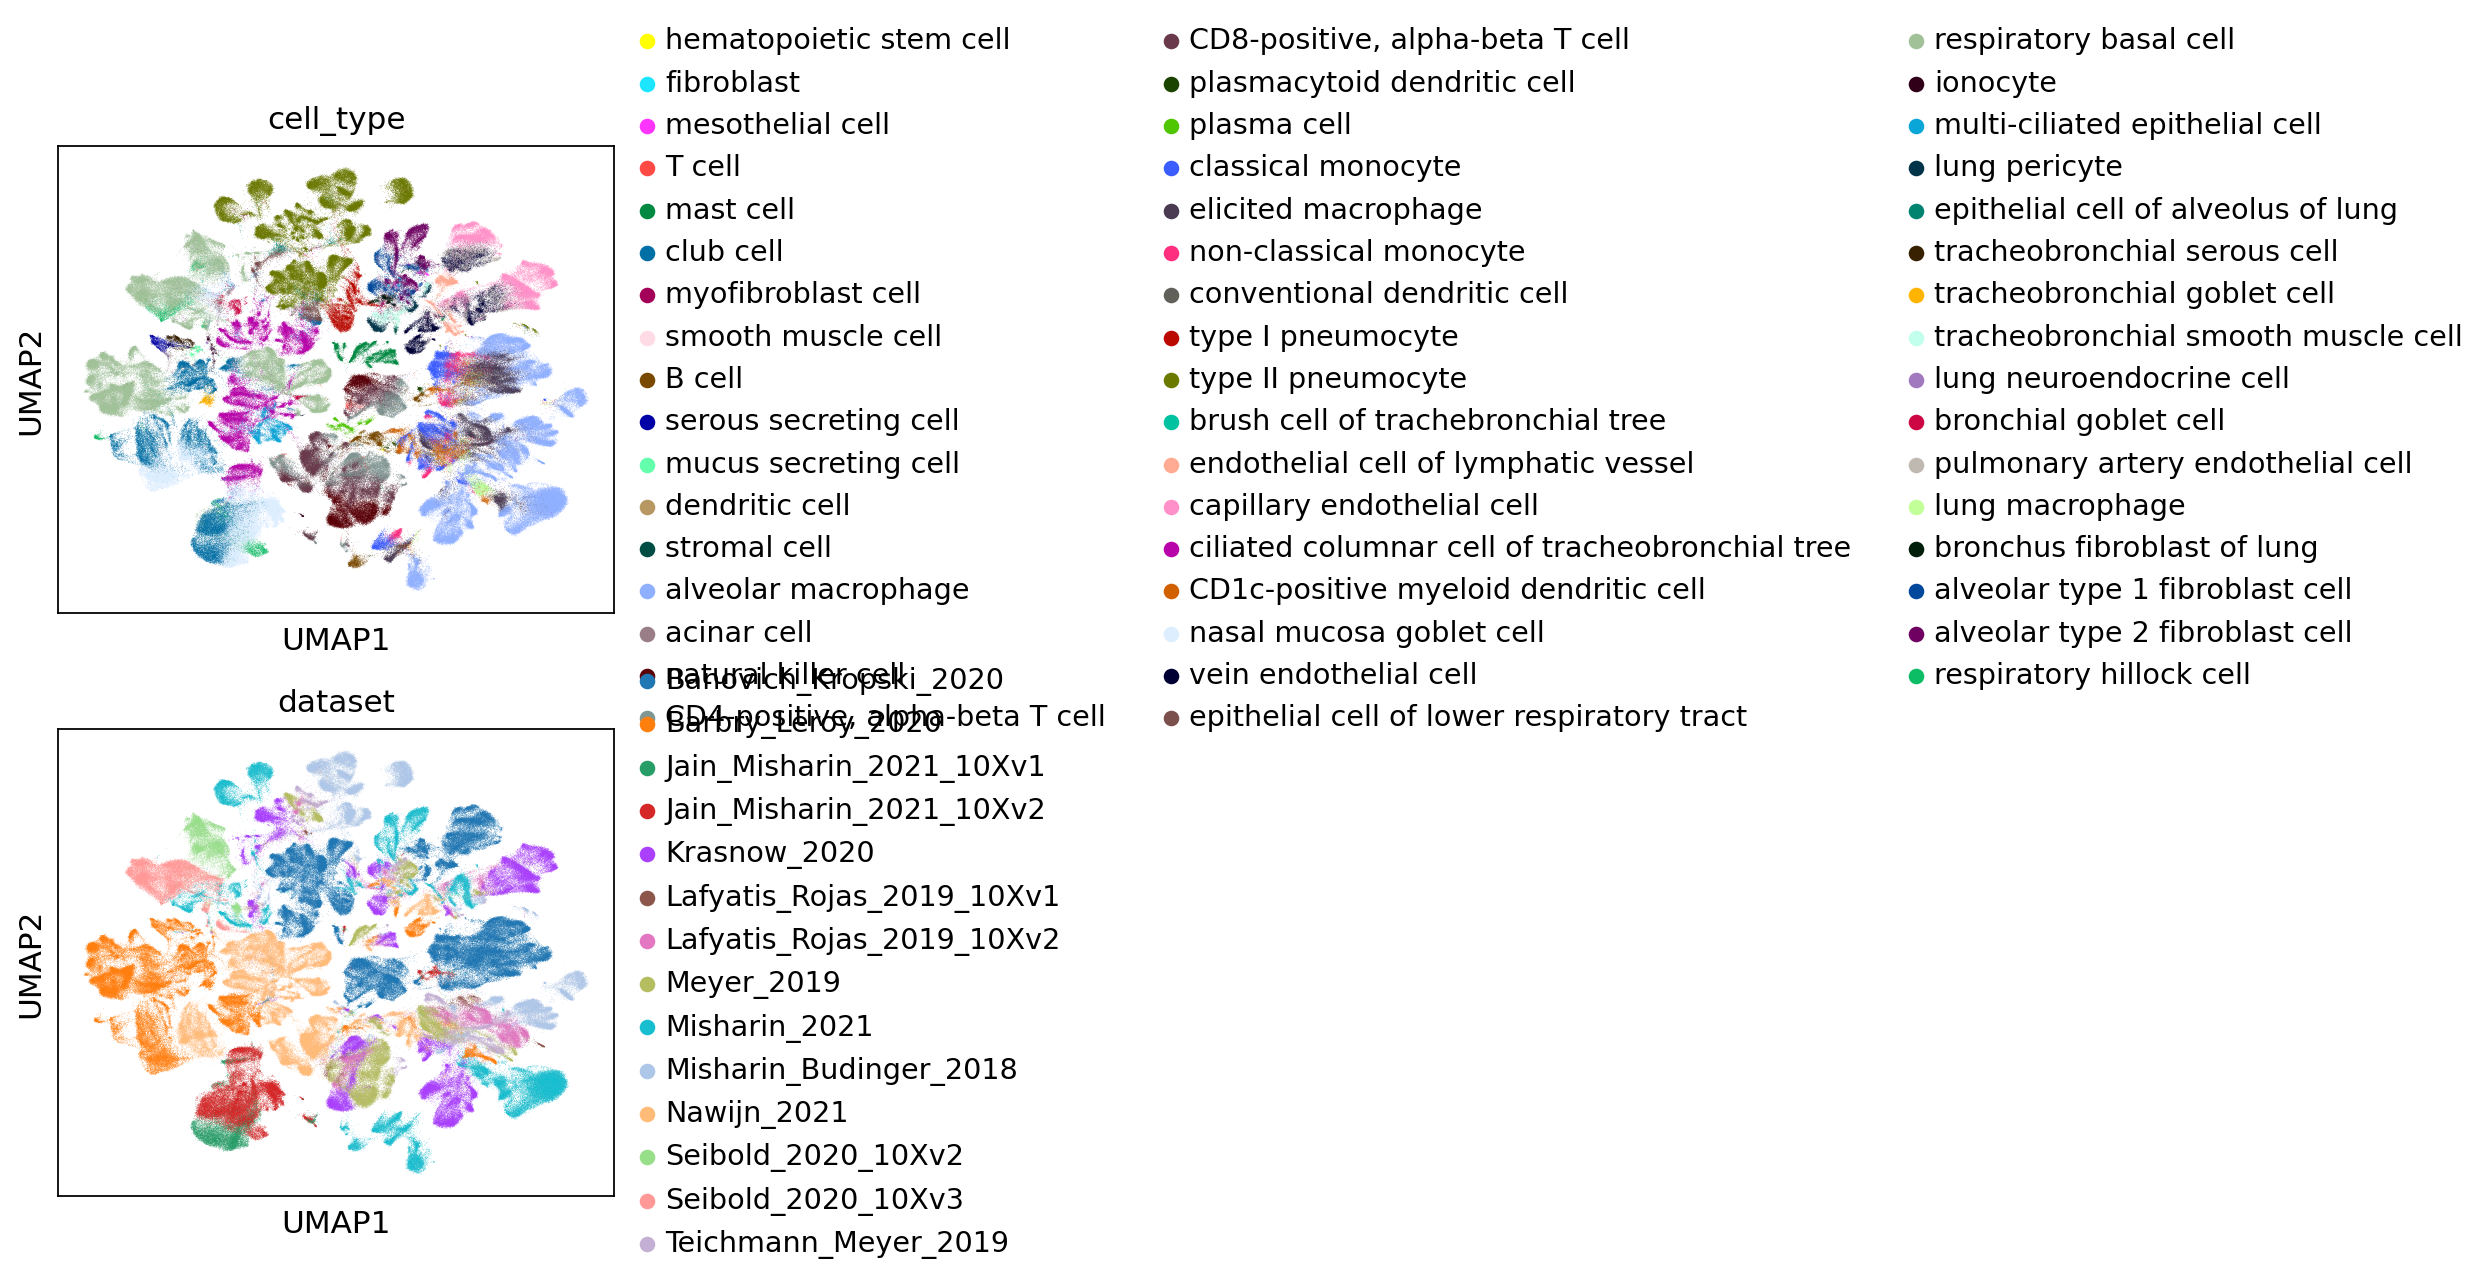

In [113]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, method='rapids')
sc.tl.umap(adata) 
sc.pl.umap(adata, color=["cell_type", "dataset"], save="_cell_type_pca.svg", ncols=1) 

In [94]:
def get_hlca_core_adata_cellxgene():
    adata_url = "https://cellxgene.cziscience.com/e/066943a2-fdac-4b29-b348-40cede398e4e.cxg/"
    # takes ~2min to load if data already downloaded
    adata = cellxgene(adata_url, filename="hlca_core.h5ad", save_path=local_dir)

    # get unnormalized, raw counts
    adata.X = adata.raw.X
    gc.collect()

    # filter to highly variable genes
    _, mvars, _, _ = scvi.model.base._utils._load_saved_files(local_dir, load_adata=False)
    adata = adata[:, adata.var.index.isin(mvars)].copy()

    # get rid of some var columns that we dont need -- will make later processing easier
    del adata.var["feature_is_filtered"]
    del adata.var["feature_reference"]
    del adata.var["feature_biotype"]

    # 4 genes are missing from cellxgene that are in the model. prepare_query_anndata will pad them with zeros.
    ArchesMixin.prepare_query_anndata(adata, local_dir)

    # add feature_names for the padded genes
    gene_ids = ['ENSG00000253701', 'ENSG00000269936', 'ENSG00000274961', 'ENSG00000279576']
    feature_names = ['AL928768.3', 'RP11-394O4.5', 'RP3-492J12.2', 'AP000769.1']
    adata.var["feature_name"] = adata.var["feature_name"].cat.add_categories(feature_names)
    for g,f in zip(gene_ids, feature_names):
        adata.var.loc[g, "feature_name"] = f

    return adata

# To print the 4 missing genes from adata run this 👇
# bdata = anndata.read_h5ad(os.path.join(local_dir, "adata.h5ad"), backed=True) # downloaded from cellxgene
# _, mvars, _, _ = scvi.model.base._utils._load_saved_files(local_dir, load_adata=False)
# a = list(mvars)
# b = list(adata.var[adata.var.index.isin(mvars)].index)
# diffs = [e for e in a if e not in b]
# print(diffs)

In [95]:
adata = get_hlca_core_adata_cellxgene()

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               
INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               
INFO     Found 99.8% reference vars in query data.                                                                 


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [98]:
adata.X.data

array([1., 1., 2., ..., 1., 4., 1.])

Finally, load the model.

In [99]:
model = scvi.model.SCANVI.load(local_dir, adata=adata, accelerator="gpu")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:221: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [100]:
temp_fig_dir = "/external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/figures"

## 2️⃣ Goodness of fit with PPC + CV

In [9]:
# run ppc+cv
# expected runtime ~5min
models_dict = {"SCANVI": model}
ppc = PPC(model.adata, models_dict, n_samples=2)

In [10]:
# expected runtime ~8min
ppc.coefficient_of_variation("features")

In [11]:
ppc

--- Posterior Predictive Checks ---
n_samples = 2
raw_counts shape = (584944, 2000)
models: ['SCANVI']
metrics: 
{
    "cv_cell": "Pandas DataFrame with shape=(584944, 2), columns=['SCANVI', 'Raw']"
}

In [34]:
pd.options.display.max_rows = 999

In [35]:
model.train_indices_

model=SCANVI | metric=cv_cell | n_cells=584944:
Mean Absolute Error=1.56,
Pearson correlation=0.92,
Spearman correlation=0.83,
R^2=0.82,



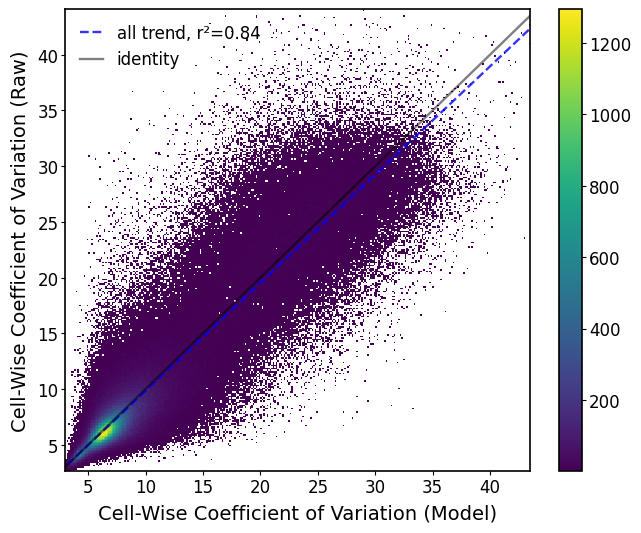

In [36]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=600, bbox_inches="tight")

In [13]:
ppc.metrics['cv_cell'].median()

SCANVI    7.446930
Raw       7.097055
dtype: float32

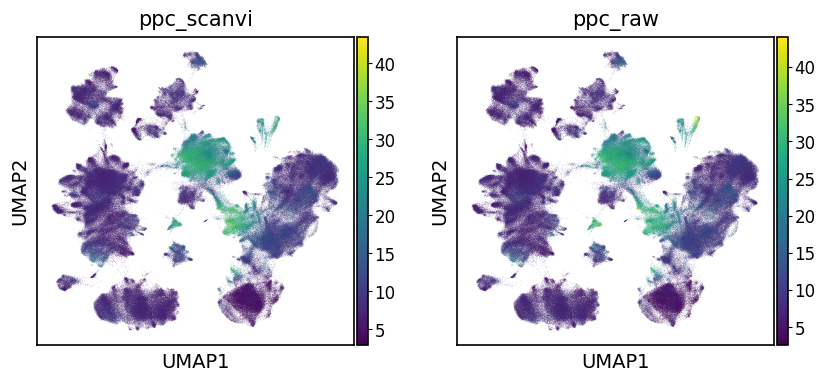

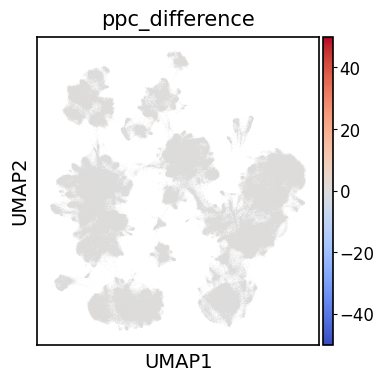

In [14]:
adata.obs['ppc_scanvi'] = ppc.metrics['cv_cell']['SCANVI']
adata.obs['ppc_raw'] = ppc.metrics['cv_cell']['Raw']
adata.obs['ppc_difference'] = (adata.obs['ppc_scanvi'] - adata.obs['ppc_raw']) / adata.obs['ppc_raw']
sc.pl.umap(adata, color=['ppc_scanvi', 'ppc_raw'])
sc.pl.umap(adata, color=['ppc_difference'], color_map='coolwarm', vmax=50, vmin=-50)

In [ ]:
adata.obs['ppc_difference'] = np.log(adata.obs['ppc_scanvi'] / adata.obs['ppc_raw'])
sc.pl.umap(adata, color=['ppc_difference', 'cell_type', 'scanvi_label'], color_map='seismic', vmax=1.0, vmin=-1.0, ncols=1, legend_fontsize=7, sort_order=False, save='ppc_cells.svg')

In [16]:
# expected runtime ~8min
ppc.coefficient_of_variation("cells")

In [17]:
ppc.metrics['cv_gene'] = np.log(ppc.metrics['cv_gene'])

/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [18]:
ppc.metrics['cv_gene'][ppc.metrics['cv_gene'] < 0] = 0

model=SCANVI | metric=cv_gene | n_cells=584944:
Mean Absolute Error=0.13,
Pearson correlation=0.97
Spearman correlation=0.98
r^2=0.94



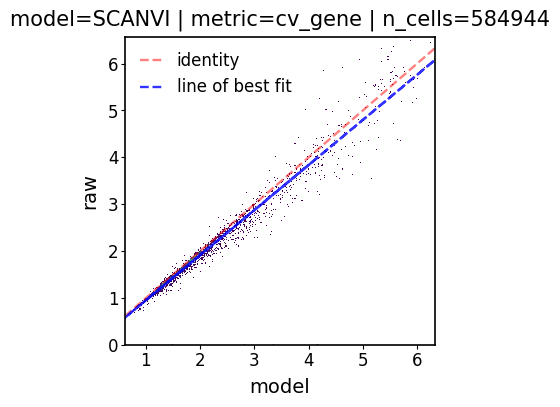

In [19]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCANVI", cell_wise=False, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/ppc_cv_gene.svg'
plt.savefig(fig_path, dpi=600, bbox_inches="tight")

model=SCANVI | metric=cv_cell | n_cells=584944:
Mean Absolute Error=1.56,
Pearson correlation=0.92
Spearman correlation=0.83
r^2=0.84



/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/cane/miniconda3/envs/resolvi/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


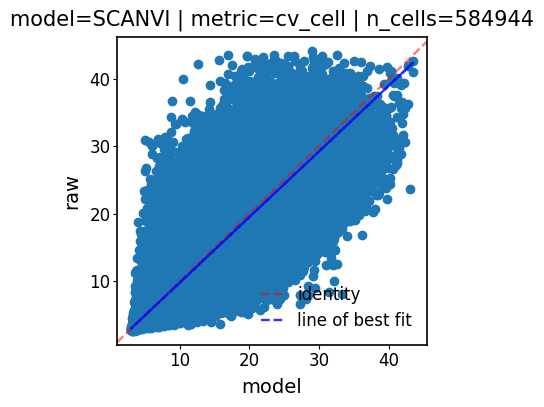

In [20]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="scatter")

## 3️⃣ Goodness of fit with PPC + DE

In [103]:
# run ppc+DE
models_dict = {"SCANVI": model}
ppc = PPC(model.adata, models_dict, n_samples=2)

In [106]:
# expected runtime <1min
ppc.differential_expression(de_groupby="ann_level_3", p_val_thresh=0.2)

In [57]:
summary_df = ppc.metrics["diff_exp"]["summary"].copy()
summary_df.index = summary_df['group']
summary_df['cell_counts'] = model.adata.obs['ann_level_3'].value_counts()
summary_df.drop(columns=['group', 'model', 'roc_auc'], inplace=True)
summary_df.to_csv(f'{temp_fig_dir}/ppc_de_summary.csv')
summary_df.head()

gene_overlap_f1   lfc_mae lfc_pearson lfc_spearman    pr_auc  \
group                                                                          
AT1                        0.93   1.37882    0.660128     0.877034  0.950651   
AT2                        0.93  0.740045    0.928514     0.975417  0.974933   
B cell lineage             0.92   0.85091    0.753955     0.926098  0.947252   
Basal                      0.93  0.485477    0.928965     0.990514  0.986899   
Dendritic cells            0.94  0.585853    0.761814     0.960293  0.955302   

                 cell_counts  
group                         
AT1                     7937  
AT2                    62405  
B cell lineage          6284  
Basal                  84713  
Dendritic cells        10319

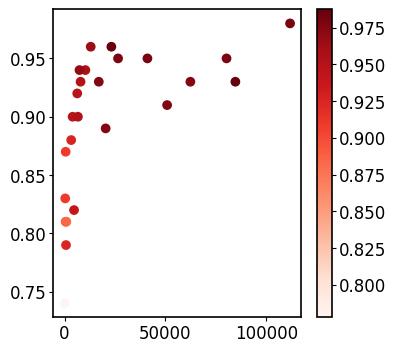

In [79]:
plt.scatter(summary_df['cell_counts'], summary_df['gene_overlap_f1'], c=summary_df['pr_auc'], cmap='Reds')
plt.colorbar()
plt.savefig('figures/ppc_de_gene_overlap.svg', dpi=600, bbox_inches="tight")

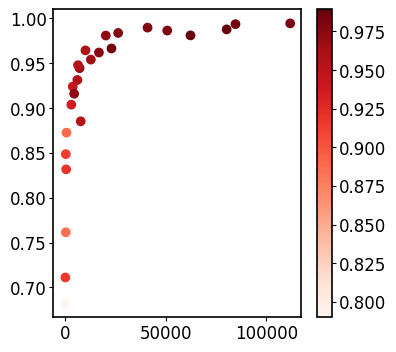

In [18]:
plt.scatter(summary_df['cell_counts'], summary_df['lfc_spearman'], c=summary_df['pr_auc'], cmap='Reds')
plt.colorbar()
plt.savefig('figures/ppc_de_spearman.svg', dpi=600, bbox_inches="tight")

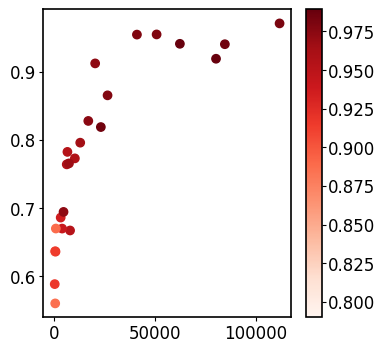

In [19]:
plt.scatter(summary_df['cell_counts'], summary_df['lfc_pearson'], c=summary_df['pr_auc'], cmap='Reds')
plt.colorbar()
plt.savefig('figures/ppc_de_pearson.svg', dpi=600, bbox_inches="tight")

In [67]:
import numpy as np
macrophage_ind = np.where(model.adata.obs['ann_level_3'] == 'Macrophages')[0]
all_other_ind = np.where(model.adata.obs['ann_level_3'] != 'Macrophages')[0]

In [68]:
df = ppc.metrics["diff_exp"]["summary"]
accumulated_df = df.loc[df['group']=='Macrophages']
accumulated_df

gene_overlap_f1   lfc_mae lfc_pearson lfc_spearman   roc_auc    pr_auc  \
13            0.97  0.873302    0.815297     0.968215  0.300808  0.957543   

          group   model  
13  Macrophages  SCANVI

In [ ]:
# expected runtime <1min
for i in [100000, 50000, 10000, 3000, 1000, 300, 100, 10]:
    macrophage_ind = np.random.choice(macrophage_ind, i, replace=False)
    ppc.differential_expression(de_groupby="ann_level_3", p_val_thresh=0.2, indices=list(macrophage_ind)+list(all_other_ind))
    df = ppc.metrics["diff_exp"]["summary"].copy()
    new_row = df[df['group'] == 'Macrophages']
    new_row.index = [len(macrophage_ind)]
    accumulated_df = accumulated_df.append(new_row)

In [73]:
accumulated_df = accumulated_df.iloc[1:]
accumulated_df['cell_counts'] = accumulated_df.index

/tmp/ipykernel_2327038/4197331866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accumulated_df['cell_counts'] = accumulated_df.index


In [75]:
accumulated_df

gene_overlap_f1   lfc_mae lfc_pearson lfc_spearman   roc_auc    pr_auc  \
100000            0.98  0.486699    0.961494     0.990459   0.30594  0.976792   
50000             0.97  0.535895    0.932497     0.987582  0.309018  0.976449   
10000             0.98  0.931252    0.786243     0.968225  0.302221  0.955274   
3000              0.97  1.550286    0.720945     0.929359  0.312089  0.940651   
1000              0.96  2.542878     0.66592     0.883047  0.342469  0.917043   
300               0.93  3.782431    0.669226     0.844916  0.379671  0.887201   
100               0.92  4.669855     0.67169     0.793753  0.377025  0.831729   
10                 0.8  4.971302    0.651771     0.682067  0.322665  0.741262   

              group   model  cell_counts  
100000  Macrophages  SCANVI       100000  
50000   Macrophages  SCANVI        50000  
10000   Macrophages  SCANVI        10000  
3000    Macrophages  SCANVI         3000  
1000    Macrophages  SCANVI         1000  
300     Macrophages  SCANVI          300  
100     Macrophages  SCANVI          100  
10      Macrophages  SCANVI           10

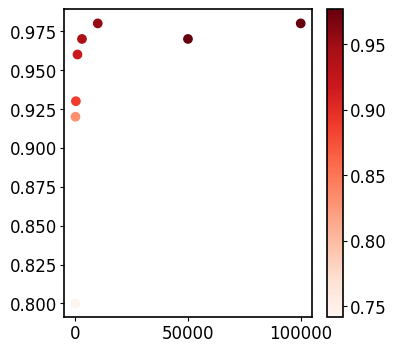

In [81]:
plt.scatter(accumulated_df['cell_counts'], accumulated_df['gene_overlap_f1'], c=accumulated_df['pr_auc'], cmap='Reds')
plt.colorbar()
plt.savefig('figures/ppc_de_gene_overlap_subsampling.svg', dpi=600, bbox_inches="tight")

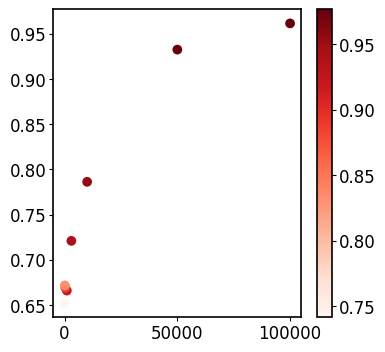

In [74]:
plt.scatter(accumulated_df['cell_counts'], accumulated_df['lfc_pearson'], c=accumulated_df['pr_auc'], cmap='Reds')
plt.colorbar()
plt.savefig('figures/ppc_de_pearson_subsampling.svg', dpi=600, bbox_inches="tight")

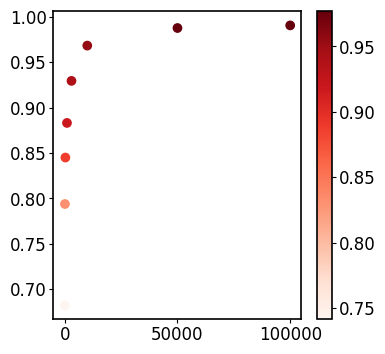

In [76]:
plt.scatter(accumulated_df['cell_counts'], accumulated_df['lfc_spearman'], c=accumulated_df['pr_auc'], cmap='Reds')
plt.colorbar()
plt.savefig('figures/ppc_de_spearman_subsampling.svg', dpi=600, bbox_inches="tight")

Plot the summary results

/home/cane/Documents/yoseflab/can/scvi-hub/scvi-hub-reproducibility/ppc_plot_utils.py:194: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.stripplot(model_de_metrics, size=4, color=".3", linewidth=1, palette=sns.color_palette("pastel"))


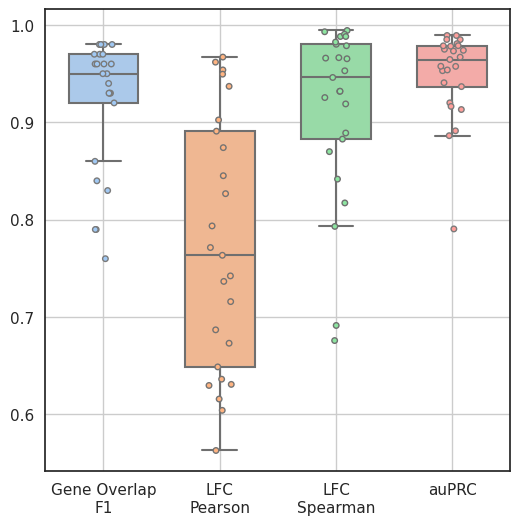

In [37]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCANVI",
    plot_kind="summary_box_with_obs",
)
fig_path = f'{temp_fig_dir}/de_summary_violin.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

Plot per-group LFC scatterplots.

In [58]:
bd = model.adata[
    model.adata.obs["ann_level_3"]=='Smooth muscle FAM83D+', ppc.metrics['diff_exp']['lfc_per_model_per_group']['SCANVI']['Smooth muscle FAM83D+'][
        np.abs(ppc.metrics['diff_exp']['lfc_per_model_per_group']['SCANVI']['Smooth muscle FAM83D+']['raw'] - ppc.metrics['diff_exp']['lfc_per_model_per_group']['SCANVI']['Smooth muscle FAM83D+']['approx'])>20].index
]

In [67]:
model.adata.obs['ann_level_3'].value_counts()

Macrophages                     111844
Basal                            84713
Secretory                        80327
AT2                              62405
T cell lineage                   50859
Multiciliated lineage            41098
Monocytes                        26529
EC capillary                     23205
Fibroblasts                      20384
Innate lymphoid cell NK          16978
EC venous                        12975
Dendritic cells                  10319
AT1                               7937
EC arterial                       7391
Mast cells                        6623
B cell lineage                    6284
Submucosal Secretory              4700
Lymphatic EC mature               4001
None                              3286
Rare                               885
Myofibroblasts                     716
Lymphatic EC differentiating       566
SM activated stress response       556
Smooth muscle FAM83D+              335
Lymphatic EC proliferating          28
Name: ann_level_3, dtype:

In [37]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCANVI",
    plot_kind="lfc_scatterplots",
)
fig_path = f'{temp_fig_dir}/de_per_group_lfc_scatter.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

KeyError: 'diff_exp'

### Let's plot the LFC dotplots.

Plot for the raw counts

In [69]:
adata_de = anndata.AnnData(X=ppc.raw_counts.to_scipy_sparse().tocsr().copy(), obs=ppc.adata.obs, var=ppc.adata.var)
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_de, "ann_level_3", use_raw=False, method="t-test")

In [76]:
import matplotlib

In [ ]:
with plt.rc_context({'font.size': 16}):
    fig_name = "raw.svg"
    sc.pl.rank_genes_groups_dotplot(
        adata_de,
        values_to_plot="logfoldchanges",
        vmax=7,
        vmin=-7,
        cmap="bwr",
        dendrogram=True,
        gene_symbols="feature_name",
        n_genes=2,
        save=fig_name,
    )

# move the figs to another directory
scanpy_fig_path = Path(f"figures/dotplot_{fig_name}").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, fig_name))

Plot for the sampled counts.

In [81]:
# X will be overwritten
adata_approx = anndata.AnnData(X=adata_de.X, obs=adata_de.obs, var=adata_de.var)
model = "SCANVI"
one_sample = ppc.samples_dataset[model].isel(samples=0)
# overwrite X with the posterior predictive sample
one_sample_data = (
    one_sample.data.to_scipy_sparse().tocsr()
    if isinstance(one_sample.data, SparseArray)
    else one_sample
)
adata_approx.X = one_sample_data.copy()
sc.pp.normalize_total(adata_approx, target_sum=1e4)
sc.pp.log1p(adata_approx)

# run DE with the imputed normalized data
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_approx, "ann_level_3", use_raw=False, method="t-test")

We need to get the N highly scored genes from the DE result on the raw data. This is needed so that we can plot the same genes for the sampled data.

In [82]:
def _get_top_n_genes_per_group(adata: anndata.AnnData, n_genes: int, var_gene_names_col: Optional[str] = None):
    rgg = adata.uns["rank_genes_groups"]
    rgg_names = pd.DataFrame.from_records(rgg["names"])
    group_to_genes = {}
    for group in rgg_names.columns:
        top_n_gene_ids = rgg_names[group].values[:n_genes]
        if var_gene_names_col is None:
            top_n_gene_names = top_n_gene_ids.tolist()
        else:
            top_n_gene_names = adata.var.loc[top_n_gene_ids][var_gene_names_col].values.tolist()
        group_to_genes[group] = top_n_gene_names
    return group_to_genes

var_names = _get_top_n_genes_per_group(adata_de, 2, "feature_name")

In [83]:
var_names

{'AT1': ['AGER', 'EMP2'],
 'AT2': ['SFTPB', 'SFTPC'],
 'B cell lineage': ['CD79A', 'IGKC'],
 'Basal': ['S100A2', 'KRT19'],
 'Dendritic cells': ['HLA-DRA', 'HLA-DPB1'],
 'EC arterial': ['IFITM3', 'CLDN5'],
 'EC capillary': ['CLDN5', 'IFI27'],
 'EC venous': ['IGFBP7', 'SPARCL1'],
 'Fibroblasts': ['DCN', 'SPARCL1'],
 'Innate lymphoid cell NK': ['NKG7', 'GNLY'],
 'Lymphatic EC differentiating': ['IGFBP7', 'PPFIBP1'],
 'Lymphatic EC mature': ['CCL21', 'IGFBP7'],
 'Lymphatic EC proliferating': ['GNG11', 'STMN1'],
 'Macrophages': ['TYROBP', 'FCER1G'],
 'Mast cells': ['TPSAB1', 'TPSB2'],
 'Monocytes': ['TYROBP', 'SRGN'],
 'Multiciliated lineage': ['C20orf85', 'CAPS'],
 'Myofibroblasts': ['DCN', 'CALD1'],
 'None': ['TPM2', 'TAGLN'],
 'Rare': ['KRT18', 'KRT8'],
 'SM activated stress response': ['TAGLN', 'TPM2'],
 'Secretory': ['WFDC2', 'SLPI'],
 'Smooth muscle FAM83D+': ['ACTA2', 'TAGLN'],
 'Submucosal Secretory': ['SLPI', 'AZGP1'],
 'T cell lineage': ['IL32', 'CD3D']}

In [86]:
adata_approx.uns['dendrogram_ann_level_3'] = adata_de.uns['dendrogram_ann_level_3']

In [ ]:
fig_name = "approx.svg"
with plt.rc_context({'font.size': 16}):
    sc.pl.rank_genes_groups_dotplot(
        adata_approx,
        values_to_plot="logfoldchanges",
        vmax=7,
        vmin=-7,
        cmap="bwr",
        dendrogram=True,
        gene_symbols="feature_name",
        var_names=var_names,
        save=fig_name,
    )

# move the figs to another directory
scanpy_fig_path = Path(f"figures/dotplot_{fig_name}").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, fig_name))

For better visualization let's plot smaller LFC dotplots, subsetted to immune cell types.

In [ ]:
immune_types = [
    "B cell lineage",
    "Dendritic cells",
    "Macrophages",
    "Mast cells",
    "Monocytes",
    # "Neutrophilic",
    "T cell lineage"
]
var_names_subset = {k: v for k, v in var_names.items() if k in immune_types}

with plt.rc_context({'font.size': 16}):
    # raw
    fig_name = "raw_subset.svg"
    sc.pl.rank_genes_groups_dotplot(
        adata_de,
        values_to_plot="logfoldchanges",
        vmax=7,
        vmin=-7,
        cmap="bwr",
        dendrogram=True,
        gene_symbols="feature_name",
        var_names=var_names_subset,
        save=fig_name + 'small.svg',
    )

    # sampled
    fig_name = "approx_subset.svg"
    sc.pl.rank_genes_groups_dotplot(
        adata_approx,
        values_to_plot="logfoldchanges",
        vmax=7,
        vmin=-7,
        cmap="bwr",
        dendrogram=True,
        gene_symbols="feature_name",
        var_names=var_names_subset,
        save=fig_name + 'small.svg',
    )

## 5️⃣ TREGs

In [9]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)

In [11]:
# run ppc+DE
models_dict = {"SCANVI": model}
ppc = PPC(model.adata, models_dict, n_samples=4)

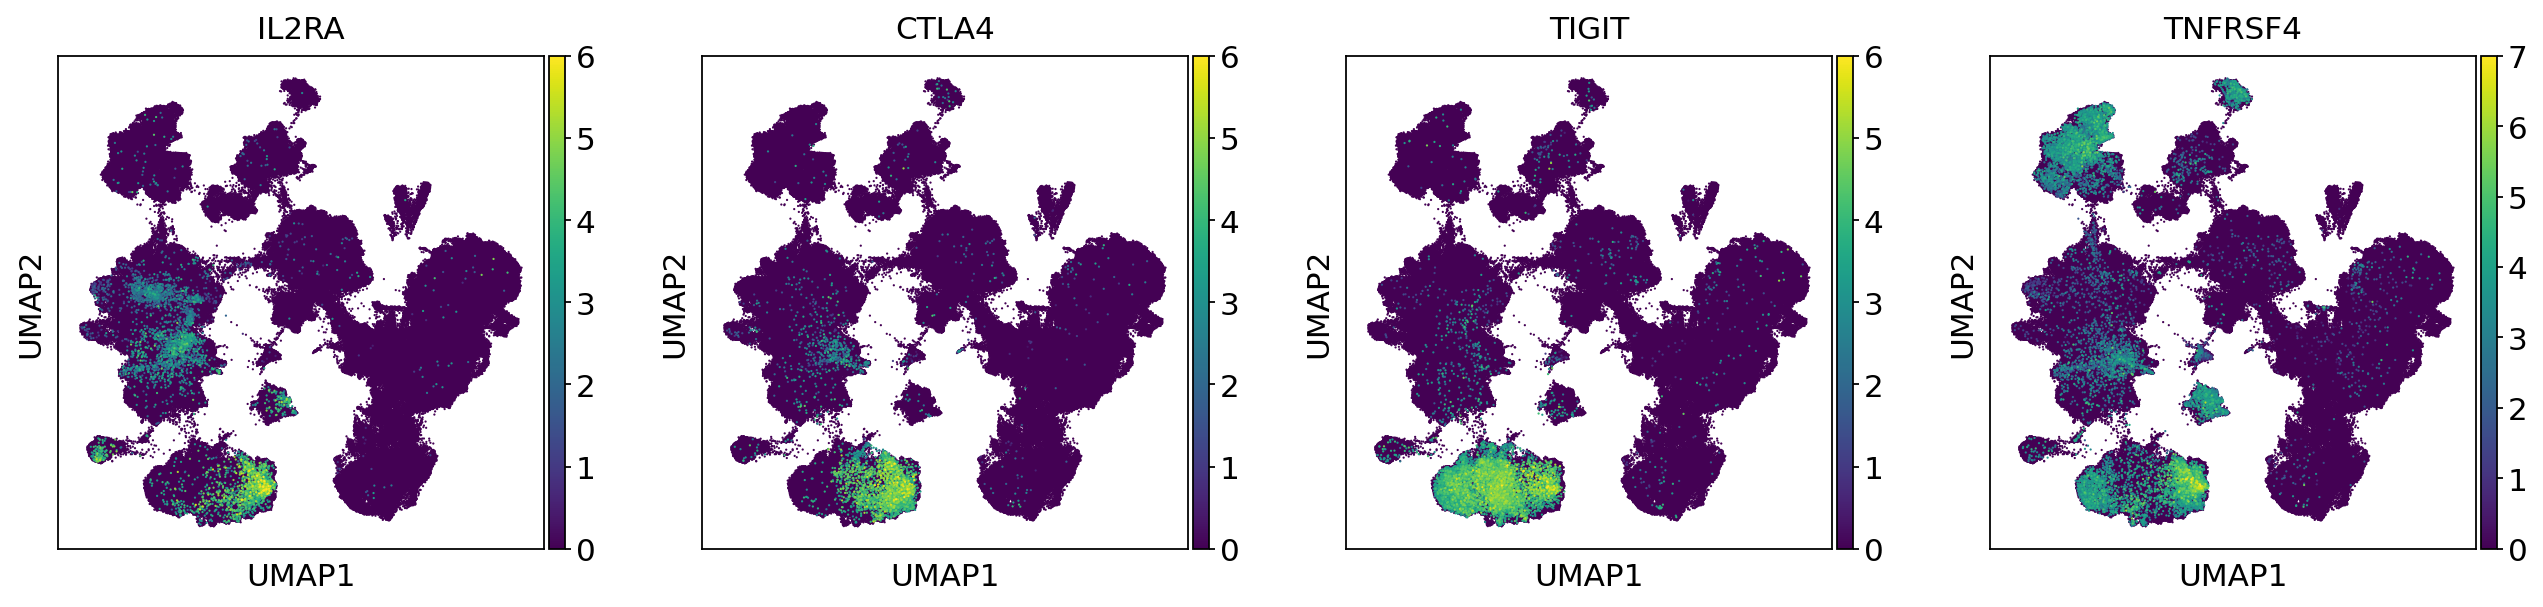

In [12]:
adata_de = anndata.AnnData(X=ppc.raw_counts.to_scipy_sparse().tocsr().copy(), obs=ppc.adata.obs, var=ppc.adata.var, obsm=ppc.adata.obsm)
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)

genes_sub = ["IL2RA", "CTLA4", "TIGIT", "TNFRSF4"]
obs_names = [i+'_imputed' for i in genes_sub]
sc.pl.umap(
    adata_de,
    color=genes_sub,
    gene_symbols='feature_name',
    size=4,
    use_raw=False,
    save="_raw_expression_treg.svg",
    vmax=[6, 6, 6, 7], vmin=0,
)

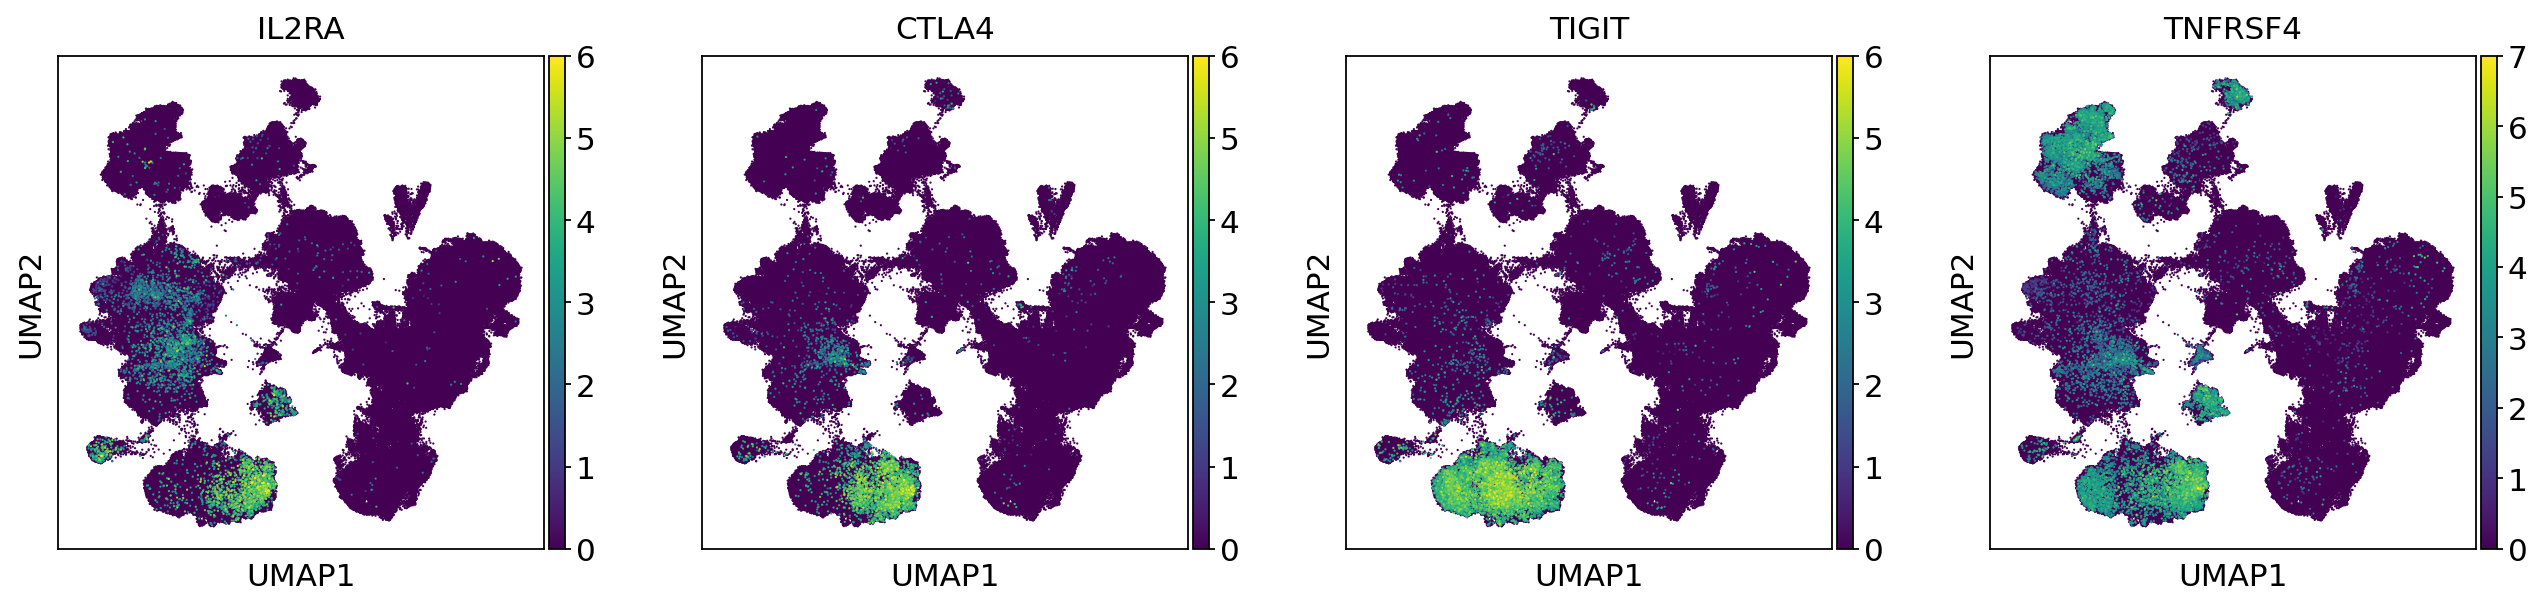

In [13]:
# X will be overwritten
adata_approx = anndata.AnnData(X=adata_de.X, obs=adata_de.obs, var=adata_de.var, obsm=ppc.adata.obsm)
model = "SCANVI"
one_sample = ppc.samples_dataset[model].isel(samples=0)
# overwrite X with the posterior predictive sample
one_sample_data = (
    one_sample.data.to_scipy_sparse().tocsr()
    if isinstance(one_sample.data, SparseArray)
    else one_sample
)
adata_approx.X = one_sample_data.copy()
sc.pp.normalize_total(adata_approx, target_sum=1e4)
sc.pp.log1p(adata_approx)

sc.pl.umap(
    adata_approx,
    color=genes_sub,
    gene_symbols='feature_name',
    size=4,
    use_raw=False,
    save="_single_expression_treg.svg",
    vmax=[6, 6, 6, 7], vmin=0,
)

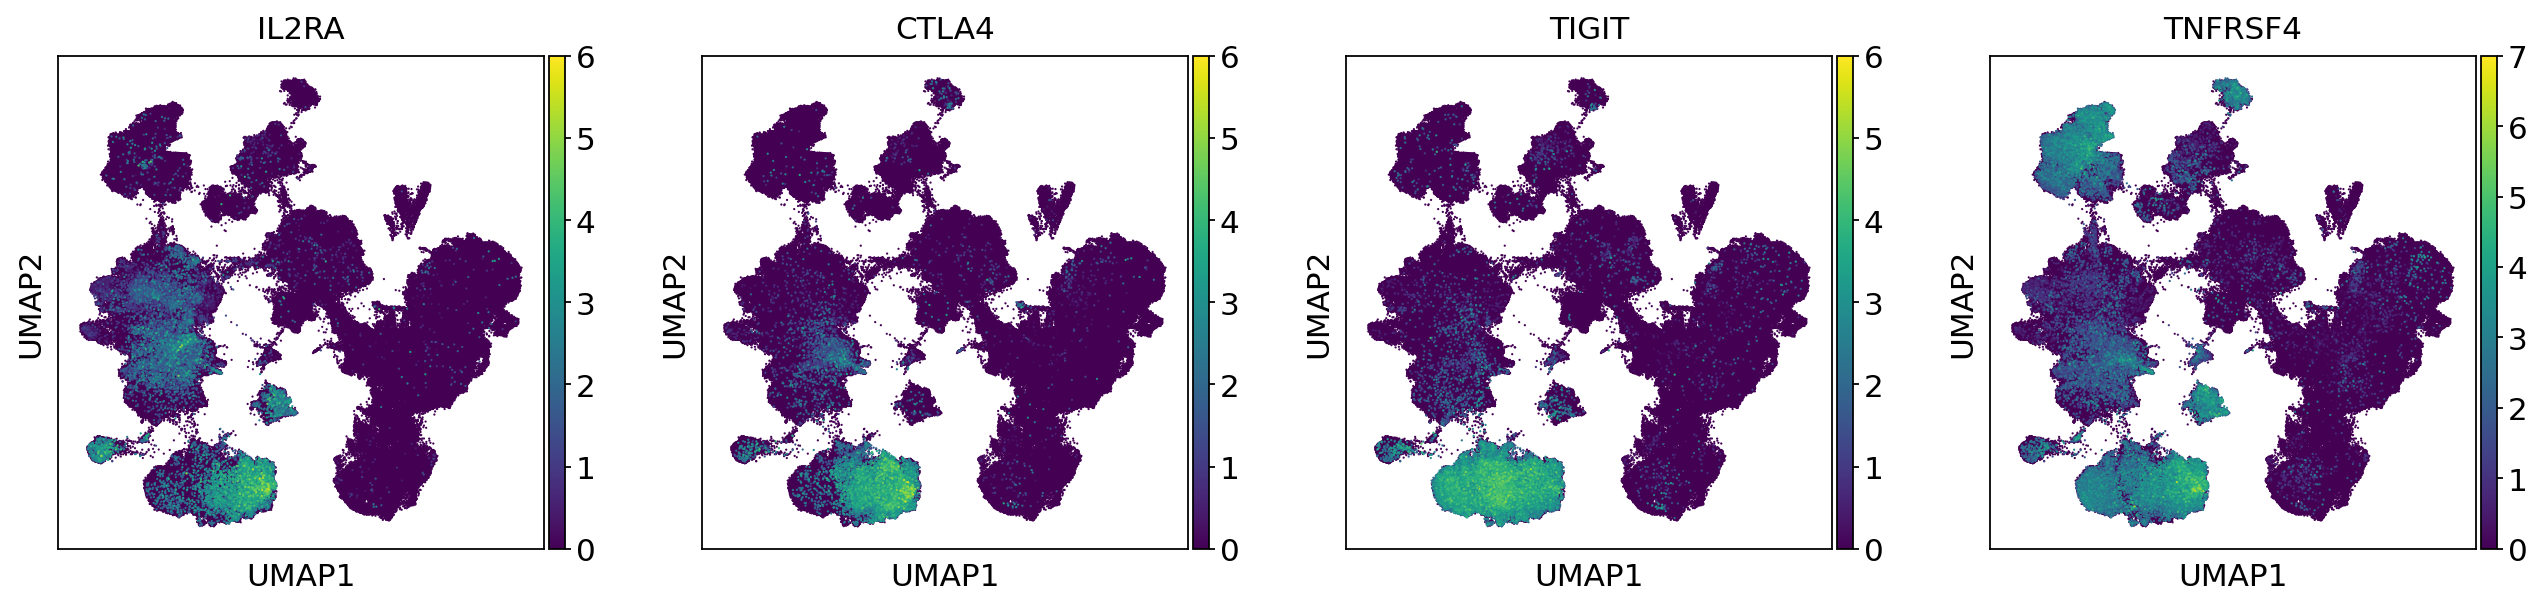

: 

In [14]:
# X will be overwritten
adata_approx = anndata.AnnData(X=adata_de.X, obs=adata_de.obs, var=adata_de.var, obsm=ppc.adata.obsm)
model = "SCANVI"
one_sample = ppc.samples_dataset[model].mean(dim="samples")
# overwrite X with the posterior predictive sample
one_sample_data = (
    one_sample.data.to_scipy_sparse().tocsr()
    if isinstance(one_sample.data, SparseArray)
    else one_sample
)
adata_approx.X = one_sample_data.copy()
sc.pp.normalize_total(adata_approx, target_sum=1e4)
sc.pp.log1p(adata_approx)

sc.pl.umap(
    adata_approx,
    color=genes_sub,
    gene_symbols='feature_name',
    size=4,
    use_raw=False,
    save="_mean_expression_treg.svg",
    vmax=[6, 6, 6, 7], vmin=0,
)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


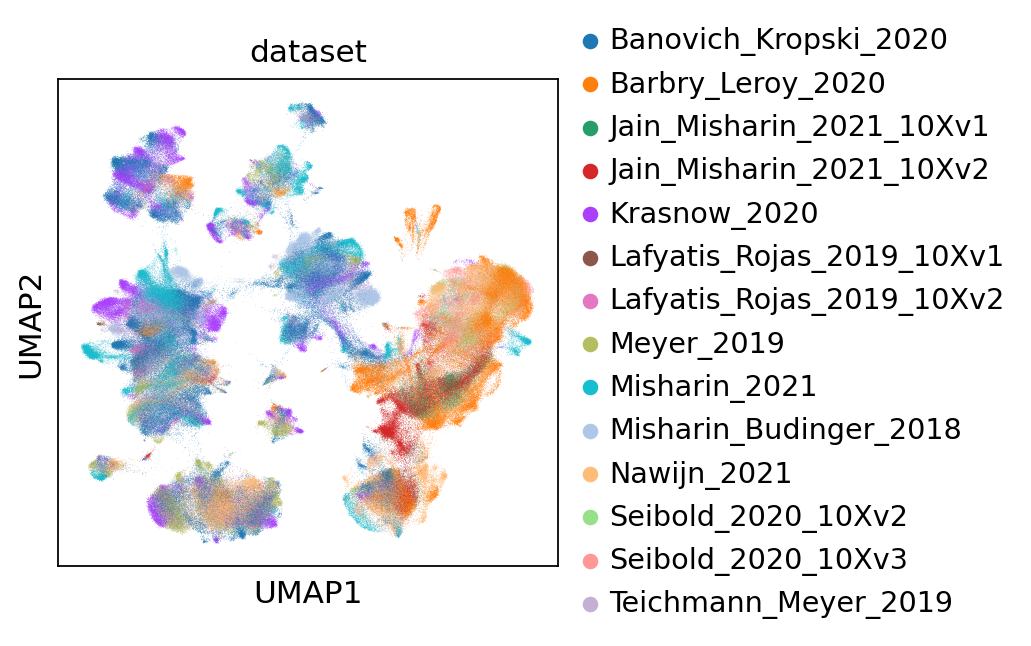

In [46]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)
# figsize: Optional[int] = None,
# color_map: Optional[str] = None,
sc.pl.umap(
    adata,
    color=["dataset"], # dataset is the batch key
    save="_dataset.svg",
    # legend_fontsize = 10,
)

In [48]:
genes = ["IL2RA", "CTLA4", "TIGIT", "TNFRSF4",]
subset_df = adata.var.loc[adata.var['feature_name'].isin(genes)]
genes_index = subset_df.index.tolist()
obs_names = [i+'_imputed' for i in subset_df['feature_name']]

In [49]:
adata.var_names = adata.var['feature_name'].astype(str)

In [54]:
model.get_normalized_expression(
    gene_list=genes,
    n_samples=50,
    weights='uniform',
    library_size=1e4,
    transform_batch='Nawijn_2021',
    return_mean=True
)

feature_name                IL2RA     CTLA4     TIGIT   TNFRSF4
GCGACCATCCCTAACC_SC22    0.178108  0.019642  0.024886  0.116947
P2_1_GCGCAACCAGTTAACC    0.108395  0.258917  7.369168  0.684945
GCTCTGTAGTGCTGCC_SC27    0.011063  0.011905  0.023127  0.053756
P2_8_TTAGGACGTTCAGGCC    0.406677  0.028904  0.038919  0.416771
CTTGATTGTCAGTTTG_T164    0.001183  0.000745  0.008589  0.008774
...                           ...       ...       ...       ...
ACCTTTACATTAACCG_T120    0.060726  0.020188  0.035092  0.098493
CATTATCTCCATGAAC_F01639  0.237573  0.277557  0.030557  0.422142
AGGCCGTGTGTGACCC-SC56    0.014996  0.004728  0.012312  0.026663
CGATGGCAGCAGGCTA-1-2     0.008656  0.002689  0.018305  0.030440
AATCGGTGTCGGCACT-1-4     0.006479  0.002635  0.024264  0.010269

[584944 rows x 4 columns]

In [66]:
adata.obs[obs_names] = model.get_normalized_expression(
    gene_list=genes,
    n_samples=1,
    weights='uniform',
    library_size=1e4,
    transform_batch='Nawijn_2021',
    return_mean=True
)

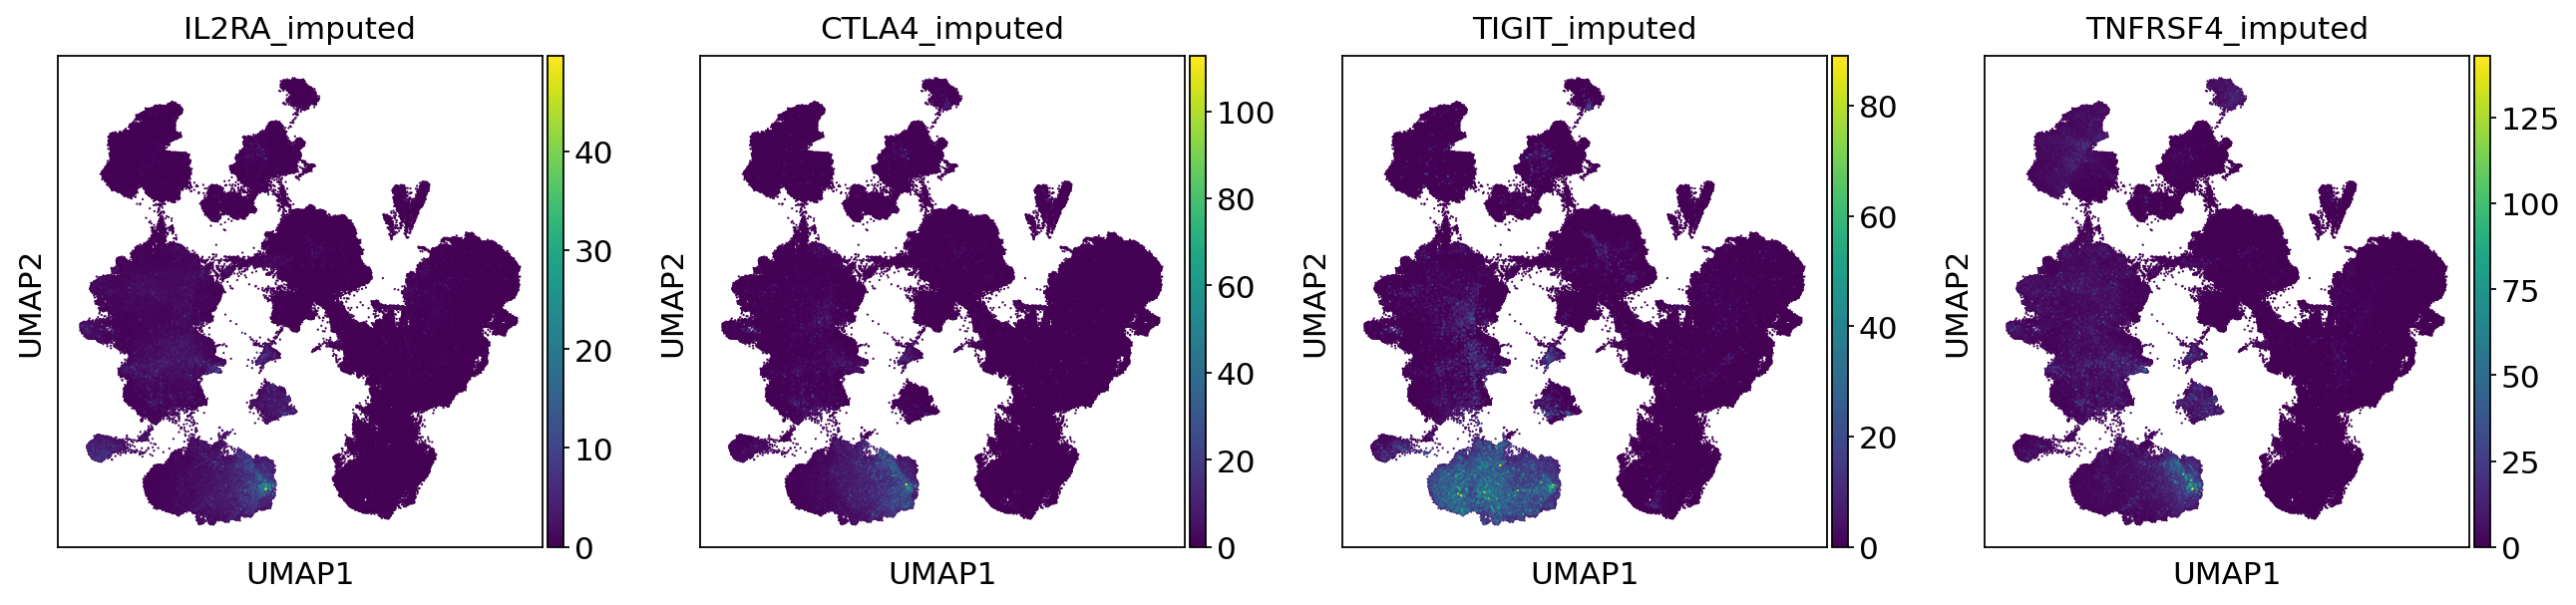

In [67]:
genes_sub = ["IL2RA", "CTLA4", "TIGIT", "TNFRSF4"]
obs_names = [i+'_imputed' for i in genes_sub]
sc.pl.umap(
    adata,
    color=obs_names,
    gene_symbols='feature_name',
    size=4,
    use_raw=False,
    save="_imputed_expression_treg.svg",
    vmin=0,
)

In [68]:
adata.obs[obs_names] = np.log1p(adata.obs[obs_names])

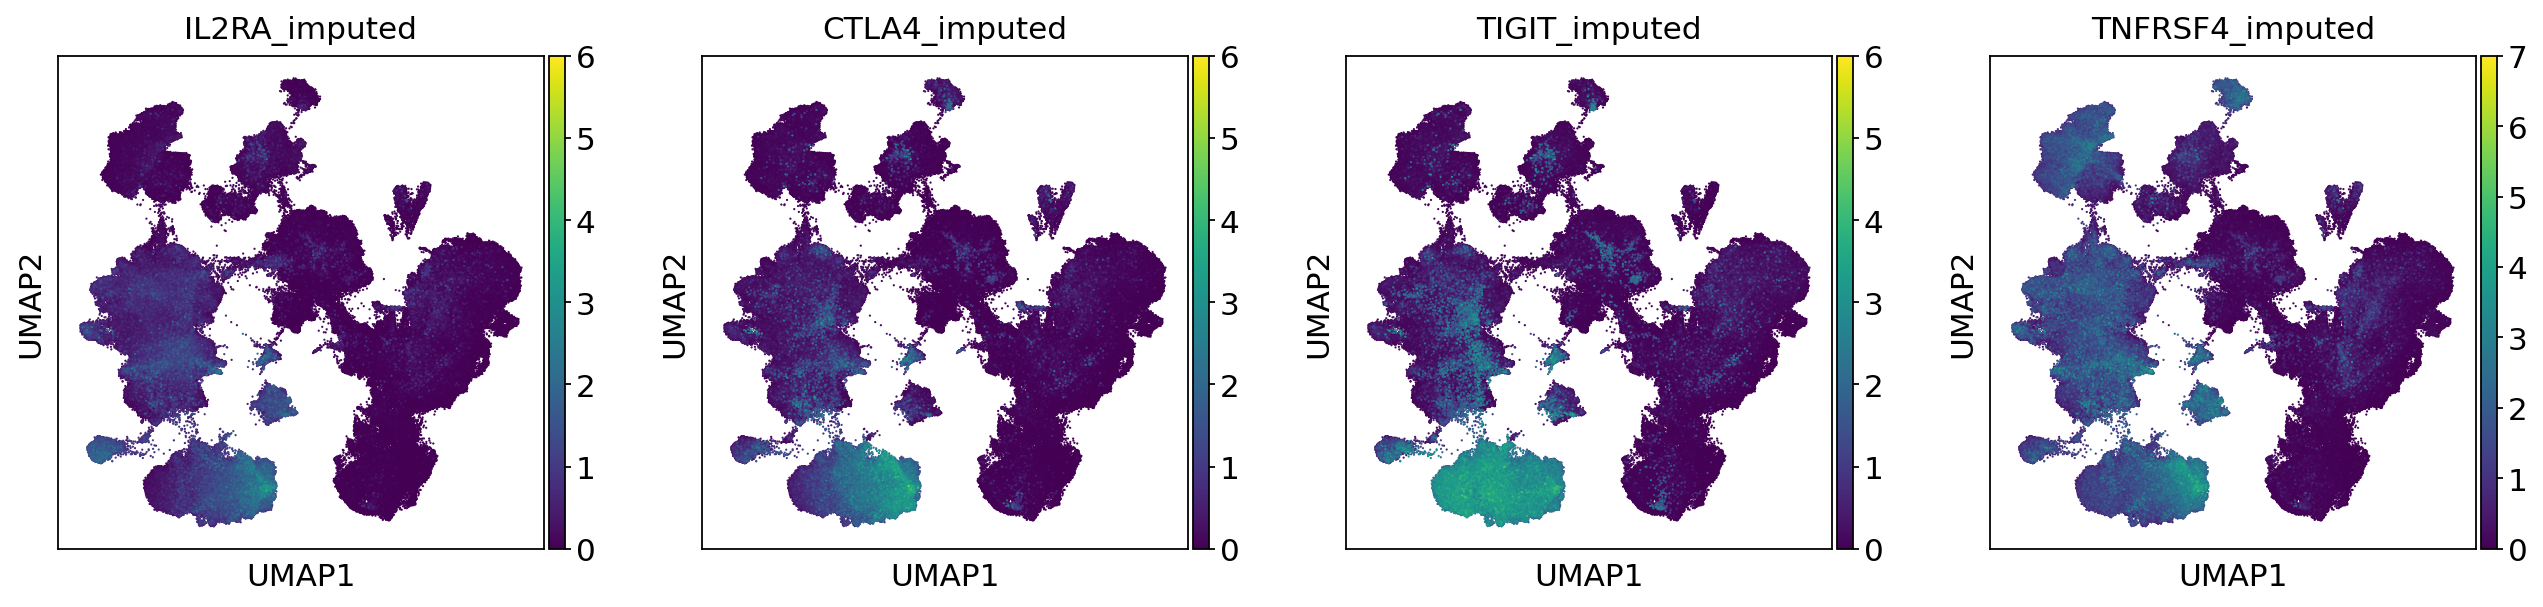

In [69]:
genes_sub = ["IL2RA", "CTLA4", "TIGIT", "TNFRSF4"]
obs_names = [i+'_imputed' for i in genes_sub]
sc.pl.umap(
    adata,
    color=obs_names,
    gene_symbols='feature_name',
    size=4,
    use_raw=False,
    save="_imputed_expression_treg.svg",
    vmax=[6, 6, 6, 7], vmin=0,
)

In [60]:
sc.pp.normalize_total(adata, target_sum=1e4)

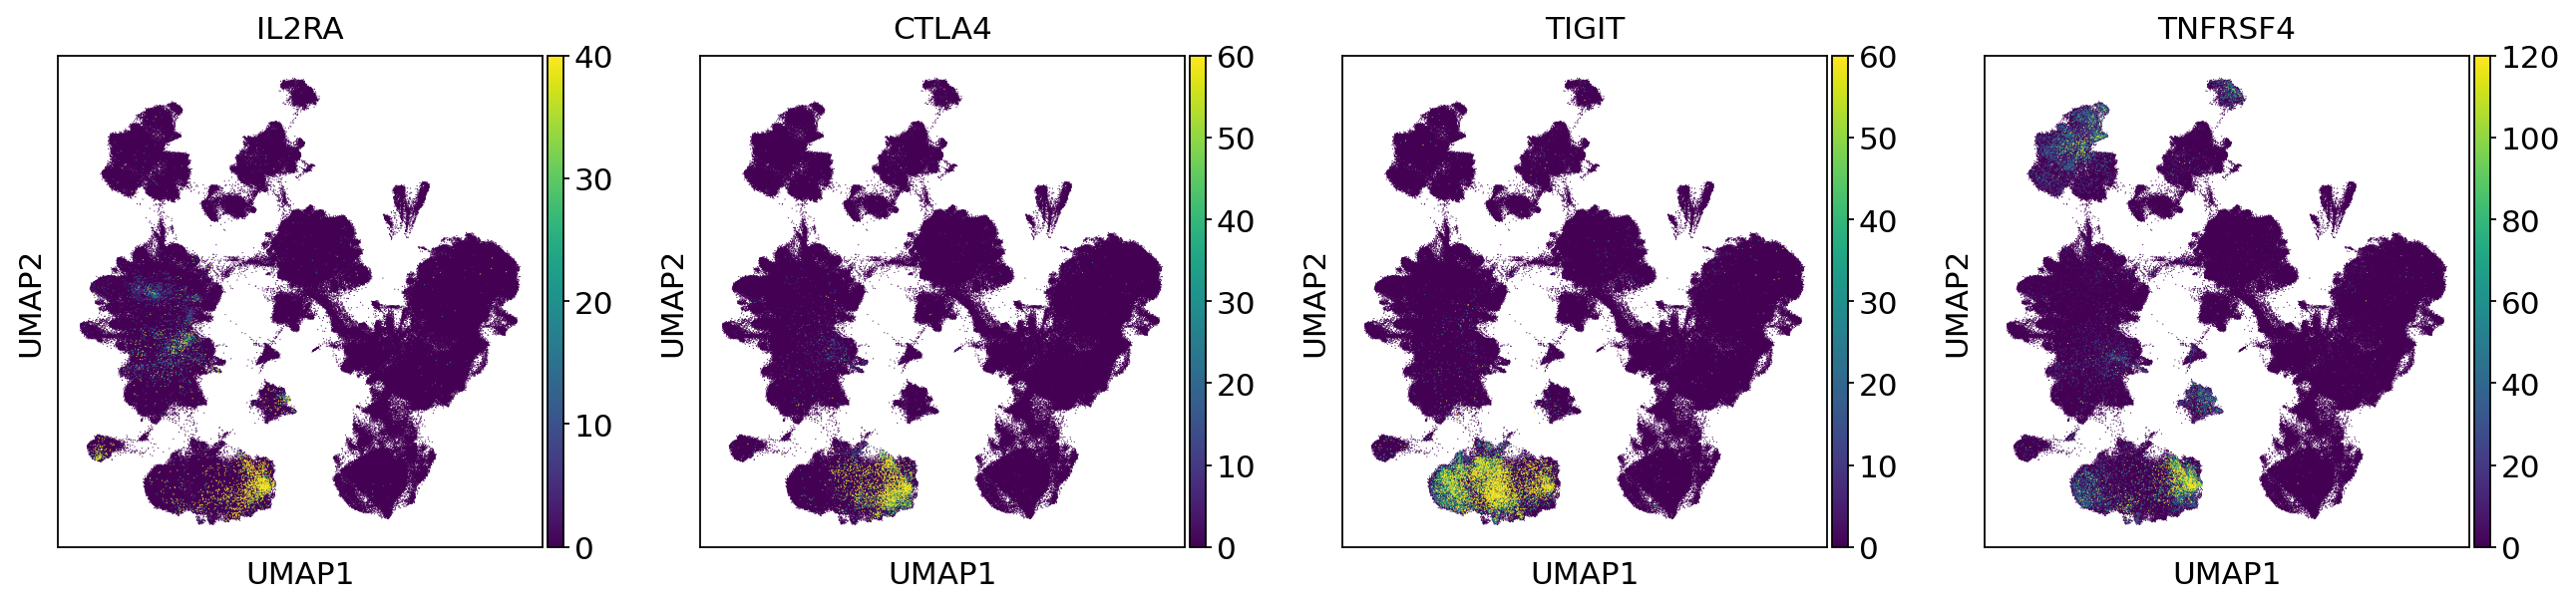

In [63]:
genes_sub = ["IL2RA", "CTLA4", "TIGIT", "TNFRSF4"]
obs_names = [i+'_imputed' for i in genes_sub]
sc.pl.umap(
    adata,
    color=genes_sub,
    size=1,
    use_raw=False,
    save="_raw_expression_treg.svg",
    vmax=[40, 60, 60, 120]
)

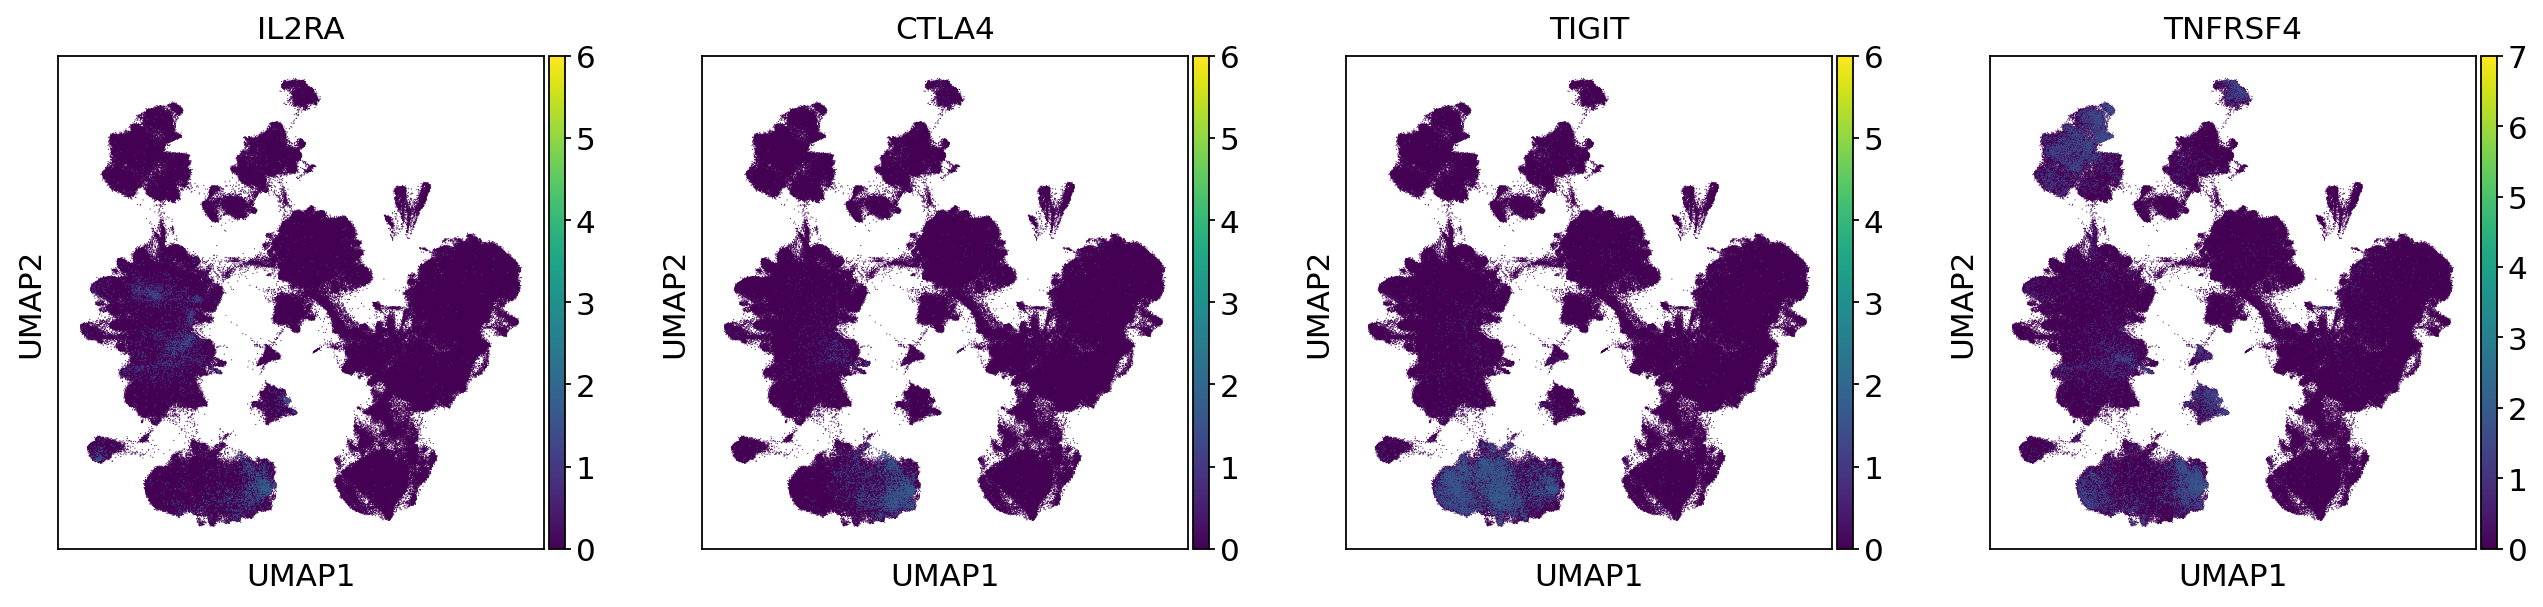

In [65]:
sc.pp.log1p(adata)
sc.pl.umap(
    adata,
    color=genes_sub,
    size=1,
    use_raw=False,
    save="_raw_expression_treg.svg",
    vmax=[6, 6, 6, 7], vmin=0,
)